In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.layers import Input, LSTM, Dense, Bidirectional, Activation, GRU
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import LambdaCallback
from sklearn import tree
from sklearn.metrics import confusion_matrix
import itertools
import time
import multiprocessing

%matplotlib inline

In [2]:
pwd = os.getcwd()
database_path = pwd[:-6] + "flightData/filtered_data/scenario4"
database_file_names = []
for root, dirs, files in os.walk(database_path):
    if not dirs:
        database_file_names = database_file_names + [os.path.join(root,file) for file in files]
print(database_file_names)

['/media/ariac/DATAPART1/mrinmoys-document/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario4/scenario4_1.csv', '/media/ariac/DATAPART1/mrinmoys-document/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario4/scenario4_2.csv', '/media/ariac/DATAPART1/mrinmoys-document/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario4/scenario4_6.csv', '/media/ariac/DATAPART1/mrinmoys-document/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario4/scenario4_7.csv', '/media/ariac/DATAPART1/mrinmoys-document/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario4/scenario4_8.csv']


In [4]:
data = pd.read_csv(database_file_names[0])
print(data.head())
X_train = data.drop(columns=['label', 'time','x','y','pitch_v','roll_v','yaw_v'])
print(X_train.head())
X_train = X_train.values
Y_train = data['label'].values
Y_train = Y_train.reshape((-1,1))

  label     pitch  pitch_v      roll  roll_v          time         x  \
0  Hold -0.000000      0.0  0.000000     0.0  1.590211e+09 -0.000006   
1  Hold -0.000000      0.0  0.000000     0.0  1.590211e+09 -0.000006   
2  Hold -0.000000      0.0  0.000000     0.0  1.590211e+09 -0.000032   
3  Hold -0.000000      0.0  0.000000     0.0  1.590211e+09 -0.000032   
4  Hold  0.022173      0.0 -0.021121     0.0  1.590211e+09 -0.000006   

        x_v         y       y_v       yaw  yaw_v         z       z_v  
0 -0.000832 -0.000001 -0.000181  0.000000    0.0  0.000001  0.000533  
1 -0.000832 -0.000001 -0.000181  0.000000    0.0  0.000001  0.000533  
2  0.000161 -0.000031 -0.000720  0.000000    0.0  0.000209  0.006912  
3  0.000161 -0.000031 -0.000720  0.000000    0.0  0.000209  0.006912  
4  0.001327 -0.000038 -0.000441 -0.036743    0.0 -0.000242  0.010795  
      pitch      roll       x_v       y_v       yaw         z       z_v
0 -0.000000  0.000000 -0.000832 -0.000181  0.000000  0.000001  0.0005

In [4]:
X_train.shape

(140163, 7)

In [6]:
x_batch = X_train[0:10,:]
x_batch.shape

(10, 7)

In [7]:
x_flatten = x_batch.reshape((1,-1))
x_flatten.shape

(1, 70)

In [8]:
x_bat1 = [x_flatten,x_flatten,x_flatten]

In [9]:
x_bat2 = np.array(x_bat1)

In [14]:
x_bat2.shape

(3, 70)

In [13]:
x_bat2=x_bat2.reshape((3,-1))

In [15]:
x_bat2[0,0:5]

array([-0.0, 0.0, -0.0008322513895109296, -0.00018102634930983183, 0.0],
      dtype=object)

In [16]:
x_flatten[0,0:5]

array([-0.0, 0.0, -0.0008322513895109296, -0.00018102634930983183, 0.0],
      dtype=object)

In [11]:
class Process(multiprocessing.Process): 
    def __init__(self, id): 
        super(Process, self).__init__() 
        self.id = id
                 
    def run(self): 
        #time.sleep(1) 
        print("I'm the process with id: {}".format(self.id))
        print("I'm the process with id: {}".format(self.id))
        print("I'm the process with id: {}".format(self.id))
        

In [3]:
# for i in range(1000):
#     p = Process(i)
#     p.start()

In [10]:
file_name = "/home/ariac/ros-intel-uav-rpeo/simulation_ws/src/pie/flightData/filtered_data/scenario1/scenario1_3.csv"
int(((file_name.split('/')[-1]).split('_')[-1]).split('.')[0])

3

In [9]:
pwd = os.getcwd()
pwd

'/home/ariac/ros-intel-uav-rpeo/simulation_ws/src/pie/script'

In [10]:
acc_by_scenario = {'scenario'+str(i+1):[[],[]] for i in range(5)}

In [11]:
acc_by_scenario

{'scenario1': [[], []],
 'scenario2': [[], []],
 'scenario3': [[], []],
 'scenario4': [[], []],
 'scenario5': [[], []]}

In [22]:
pwd = os.getcwd()
all_file_names = []
scenarios = ['scenario'+str(i+1) for i in range(5)]
data_dist_table = pd.DataFrame(index=['Hold','Takeoff','Hover','Search','Loiter','Obstacleavoid','Land'])
for scenario in scenarios:
    count_dict = {'Hold':0,'Takeoff':0,'Hover':0,'Search':0,'Loiter':0,'Obstacleavoid':0,'Land':0}
    database_path = pwd[:-6] + "flightData/filtered_data/"+scenario
    database_file_names = []
    for root, dirs, files in os.walk(database_path):
        database_file_names = [os.path.join(root,file) for file in files]
    all_file_names += database_file_names
    for file in database_file_names:
        data = pd.read_csv(file)
        label_count = data['label'].value_counts()
        print(data['time'][63]-data['time'][0])
        for indx in label_count.index:
            count_dict[indx] += label_count[indx]
    data_dist_table[scenario] = count_dict.values()
print(data_dist_table) 

1.0508711338043213
1.0410828590393066
1.0641930103302002
1.0548598766326904
1.052947998046875
1.0507028102874756
1.0478050708770752
1.0500290393829346
1.0481820106506348
1.0546960830688477
1.0479819774627686
1.050018072128296
1.0488409996032715
1.0483078956604004
1.052245855331421
1.048624038696289
1.0485329627990723
1.0559089183807373
1.0499839782714844
1.0480949878692627
1.0483589172363281
1.0516610145568848
1.048658847808838
1.051227331161499
1.046910047531128
               scenario1  scenario2  scenario3  scenario4  scenario5
Hold               13264      13287      64310      57328      23519
Takeoff             1813       1844       1900       1858       1801
Hover               9001       9000       9045       9001       9014
Search                 0     109788     204655     541196     319726
Loiter                 0          0      83451          0      51460
Obstacleavoid          0          0          0      17441      11533
Land                1940       2088       1986   

([<matplotlib.patches.Wedge at 0x7f1cf5fdeba8>,
 [Text(1.0361094498444814, 0.3694282175781465, 'Hold'),
  Text(0.8389229899986013, 0.7114831107284324, 'Takeoff'),
  Text(0.7571330249742301, 0.7979659030894567, 'Hover'),
  Text(-1.094010222105382, -0.11463696580480792, 'Search'),
  Text(1.002768285063901, -0.4521678520969876, 'Loiter'),
  Text(1.0948587053850016, -0.10622812830262363, 'Obstacleavoid'),
  Text(1.0997916368547058, -0.0214092387638442, 'Land')])

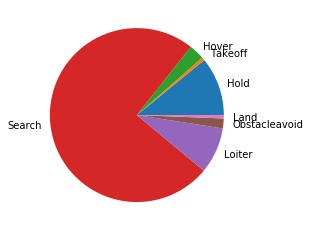

In [21]:
data = data_dist_table['scenario1']+data_dist_table['scenario2']+data_dist_table['scenario3']+data_dist_table['scenario4']+data_dist_table['scenario5']

plt.pie(data,labels=['Hold','Takeoff','Hover','Search','Loiter','Obstacleavoid','Land'])

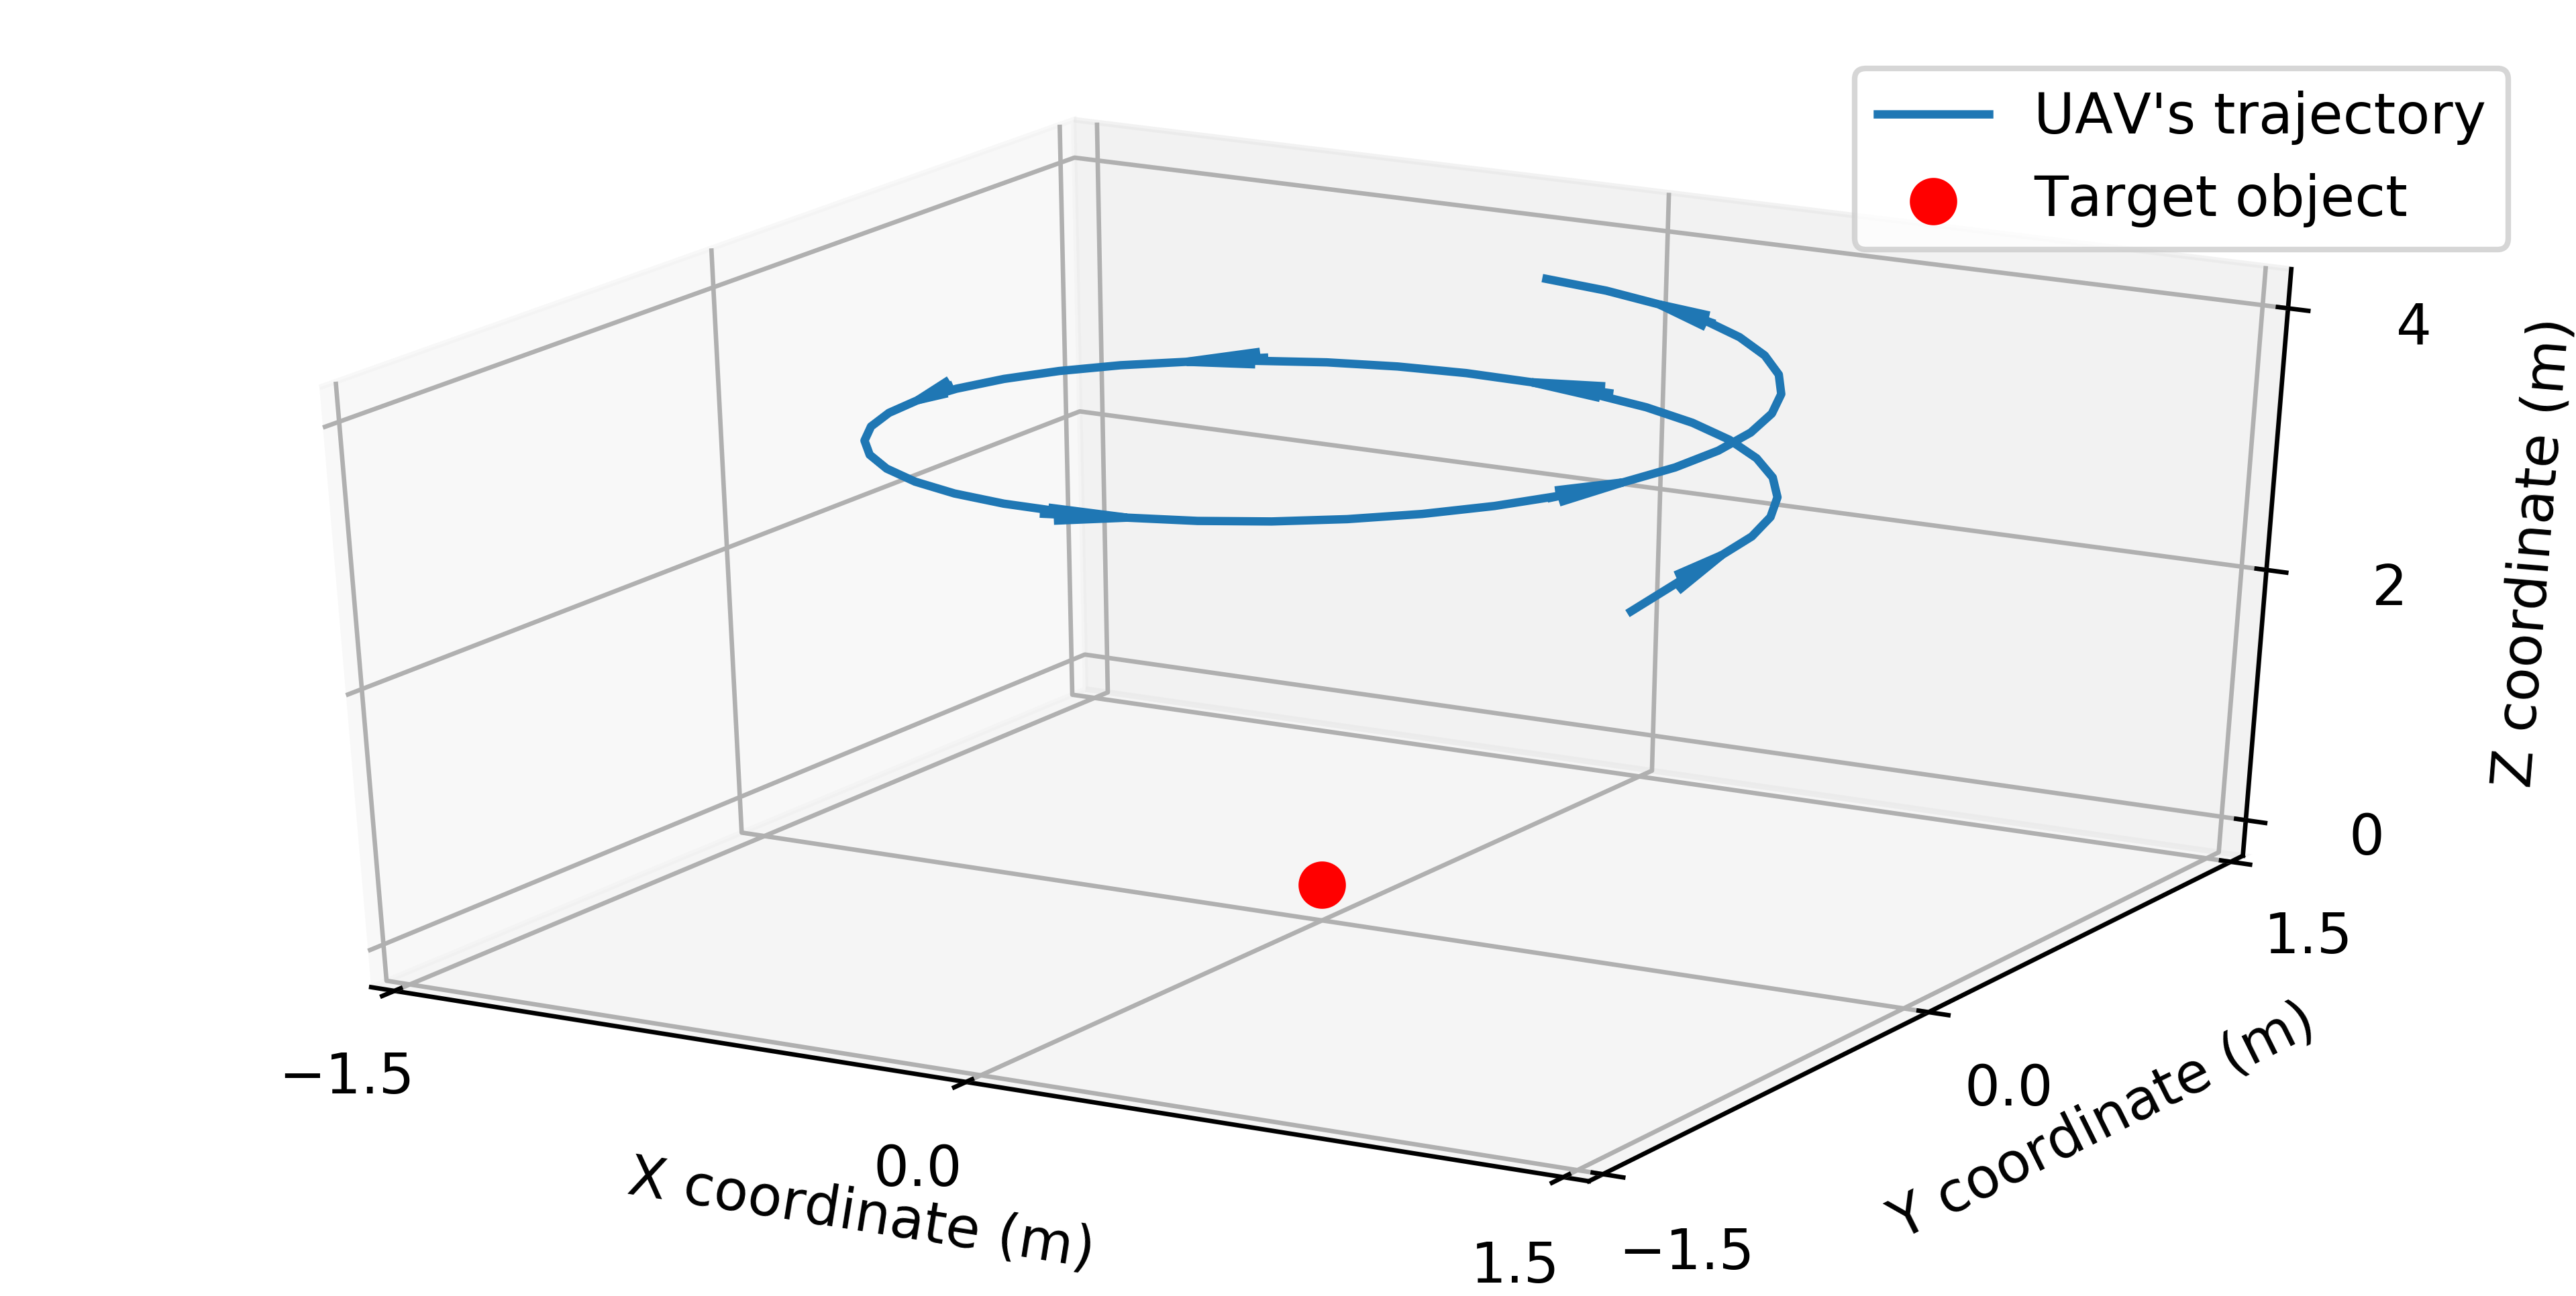

In [68]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch


fig = plt.figure(figsize=[8,4], dpi=600)
ax = fig.add_subplot(111, projection='3d')

ang = np.linspace(0,2.5*np.pi,50)
x = np.cos(ang)
y = np.sin(ang)
z = np.linspace(3,4,50)

ax.plot(x, y, z, label="UAV's trajectory")
ax.quiver(x[0], y[0], z[0], x[1]-x[0], y[1]-y[0], z[1]-z[0], length=.5, pivot='tip', arrow_length_ratio=.5, normalize=True)
ax.quiver(x[10], y[10], z[10], x[11]-x[10], y[11]-y[10], z[11]-z[10], length=.2, pivot='tip', arrow_length_ratio=.9, normalize=True)
ax.quiver(x[15], y[15], z[15], x[16]-x[15], y[16]-y[15], z[16]-z[15], length=.2, pivot='tip', arrow_length_ratio=.9, normalize=True)
ax.quiver(x[20], y[20], z[20], x[21]-x[20], y[21]-y[20], z[21]-z[20], length=.2, pivot='tip', arrow_length_ratio=.9, normalize=True)
ax.quiver(x[30], y[30], z[30], x[31]-x[30], y[31]-y[30], z[31]-z[30], length=.2, pivot='tip', arrow_length_ratio=.9, normalize=True)
ax.quiver(x[37], y[37], z[37], x[37]-x[36], y[37]-y[36], z[37]-z[36], length=.2, pivot='tip', arrow_length_ratio=.9, normalize=True)
ax.quiver(x[47], y[47], z[47], x[47]-x[46], y[47]-y[46], z[47]-z[46], length=.2, pivot='tip', arrow_length_ratio=.9, normalize=True)


ax.scatter(0,0,0,color='red',lw=4.0, label='Target object')


ax.legend(loc='best')
ax.set_xlabel('X coordinate (m)')
ax.set_ylabel('Y coordinate (m)')
ax.set_zlabel('Z coordinate (m)')
ax.set_xlim(-1.5,1.5)
ax.set_ylim(-1.5,1.5)
ax.set_xticks([-1.5,0,1.5])
ax.set_yticks([-1.5,0,1.5])
ax.set_zticks([0,2,4])